In [1]:
import boto3
import pandas as pd
from io import StringIO
import os

First let's grab some timeseries data using the boto3 package in Python

In [2]:
# Get the global gid csv file
# Initialize boto3 client
s3_client = boto3.client('s3')

# Define the S3 bucket and file path
bucket_name = 'era5-for-wrf'
file_key = 'era5_global_gids.csv'

# Get the file object
s3_object = s3_client.get_object(Bucket=bucket_name, Key=file_key)

# Read the file content
file_content = s3_object['Body'].read().decode('utf-8')

# Use StringIO to convert the file content to a file-like object
csv_string_io = StringIO(file_content)

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_string_io, index_col = 0)

# Display the DataFrame
print(df)

NoCredentialsError: Unable to locate credentials

In [2]:
# Now let's define a function to return the GID for a given latitude and longitude
def get_gid(lat, lon, gid_df):
    # Round to the nearest 0.25 degrees
    lat = round(lat*4)/4
    lon = round(lon*4)/4

    # Find entry in gid_df with those lat/lons
    gid = gid_df[(gid_df['lat'] == lat) & (gid_df['lon'] == lon)]['gid'].values[0]

    # Return result
    return str(gid).zfill(7)

In [7]:
# Let's test it out
lat = 52.52
lon = 13.405
gid = get_gid(lat, lon, df)
print(f"The GID for latitude {lat} and longitude {lon} is {gid}")

NameError: name 'df' is not defined

In [6]:
# Now let's use the GID to download our data
# Define the S3 bucket and file path
bucket_name = 'era5-for-wrf'
file_key = f'global_single_level/cells/{gid}/timeseries.csv'

# Get the file object
s3_object = s3_client.get_object(Bucket=bucket_name, Key=file_key)

# Read the file content
file_content = s3_object['Body'].read().decode('utf-8')

# Use StringIO to convert the file content to a file-like object
csv_string_io = StringIO(file_content)

# Read the CSV file into a Pandas DataFrame
era5_df = pd.read_csv(csv_string_io, index_col = 0, skiprows = 1, parse_dates = True)

NameError: name 'gid' is not defined

In [21]:
# Let's look at the data
era5_df

,100-m wind speed (m/s),100-m wind direction (degrees),2-m temperature (K),surface pressure (Pa)
datetime,,,,
2000-01-01 00:00:00,4.09,190.88,272.30,101777.43
2000-01-01 01:00:00,4.05,193.58,272.50,101801.09
2000-01-01 02:00:00,4.19,197.67,272.38,101809.48
2000-01-01 03:00:00,4.25,199.57,272.37,101785.27
2000-01-01 04:00:00,4.30,200.83,272.70,101759.05
...,...,...,...,...
2024-03-31 19:00:00,3.93,298.71,285.64,99383.31
2024-03-31 20:00:00,4.07,316.15,284.35,99398.93
2024-03-31 21:00:00,4.12,340.19,283.41,99366.82


Now if we wanted to avoid the boto3 route, we can simply download data using AWS CLI: 

In [23]:
cmd = f"aws s3 cp s3://era5-for-wrf/global_single_level/cells/{gid}/timeseries.csv ."

os.system(cmd)

0

# Plotting the downloaded model level data

In [8]:
import xarray as xr
ds_u = xr.open_dataset('data/e5.oper.an.ml.0_5_0_2_2_u.regn320uv.2021062118_2021062123.nc')
ds_v = xr.open_dataset('data/e5.oper.an.ml.0_5_0_2_3_v.regn320uv.2021062118_2021062123.nc')

In [10]:
ws = (ds_u.U**2 + ds_v.V**2)**0.5

In [12]:
ws.longitude

<xarray.DataArray 'longitude' (longitude: 1280)> Size: 10kB
array([0.000000e+00, 2.812500e-01, 5.625000e-01, ..., 3.591562e+02,
       3.594375e+02, 3.597188e+02])
Coordinates:
  * longitude  (longitude) float64 10kB 0.0 0.2812 0.5625 ... 359.2 359.4 359.7
Attributes:
    long_name:      longitude
    standard_name:  longitude
    short_name:     lon
    units:          degrees_east

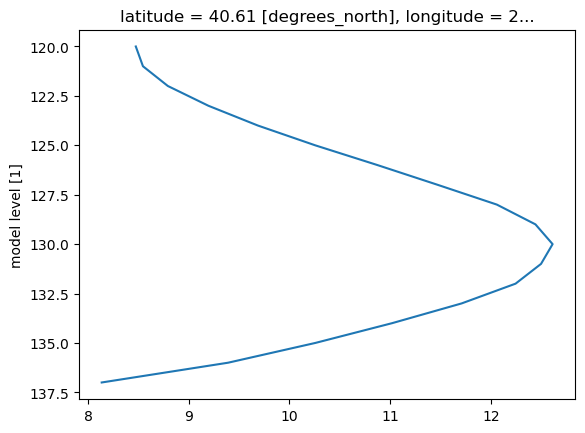

In [ ]:
import matplotlib.pyplot as plt
ws.sel(time='2021-06-21T21:00:00',level=slice(120,None)).sel(latitude=40.65025, longitude=-73.5054+360,method='nearest').plot(y='level')
# inverte the level axis
plt.gca().invert_yaxis()

In [22]:
import xarray as xr
ds_u = xr.open_dataset('data/e5.oper.an.ml.0_5_0_2_2_u.regn320uv.2001070518_2001070523.nc')
ds_v = xr.open_dataset('data/e5.oper.an.ml.0_5_0_2_3_v.regn320uv.2001070518_2001070523.nc')
ws = (ds_u.U**2 + ds_v.V**2)**0.5

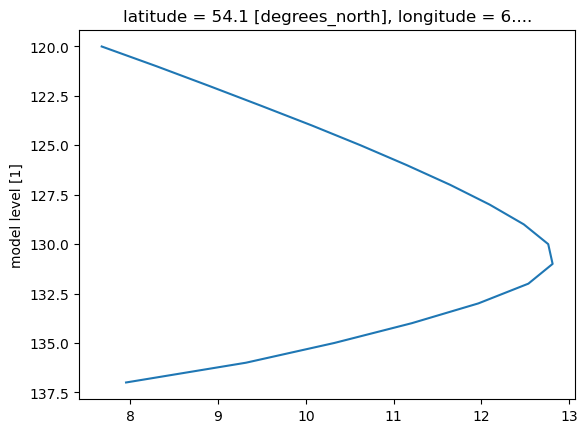

In [23]:
import matplotlib.pyplot as plt
ws.sel(time='2001-07-05T23:00:00',level=slice(120,None)).sel(latitude=54.0148618, longitude=6.5876398,method='nearest').plot(y='level')
# inverte the level axis
plt.gca().invert_yaxis()